# Przewidywanie typów gwiazd

Naszym celem będzie stworzenie modelu zdolnego do przewidywania typu gwiazdy na podstawie kilku atrybutów opisowych. Będziemy testować 4 różne klasyfikatory: najbliższych sąsiadów, prototypów, naiwny Bayesa oraz drzew decyzyjnych.

Temat projektu jest oparty na zbiorze danych stworzonych przez jednego z użytkowników serwisu https://www.kaggle.com/ - Deepraj Baidya. Opis danych stworzony przez twórcę zestawu znajduje się na stronie https://www.kaggle.com/deepu1109/star-dataset.

### Potrzebne pakiety

Do analizy danych i stworzenia modelu przewidującego typ gwiazd będziemy używać następujących pakietów.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

# do skalowania danych
from sklearn.preprocessing import StandardScaler
# do zamiany atrybutów kategorycznych na ilościowe
from sklearn.preprocessing import OrdinalEncoder
# podział zbioru danych na dane treningowe i testowe
from sklearn.model_selection import train_test_split
# testowane klasyfikatory
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestCentroid
from sklearn.naive_bayes import GaussianNB
from sklearn import tree

## Zestaw danych

Zestaw danych składa się z 240 rekordów. Każdy z nich zawiera 6 cech opisowych oraz 1 atrybut decyzyjny - typ gwiazdy. Większość danych została wstawiona z informacji o gwiazdach znalezionych w internecie. Część braków została uzupełniona za pomocą równań astronomicznych (tak napisał autor).

In [2]:
stars_raw = pd.read_csv('6 class csv.csv')
print(stars_raw.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Temperature (K)         240 non-null    int64  
 1   Luminosity(L/Lo)        240 non-null    float64
 2   Radius(R/Ro)            240 non-null    float64
 3   Absolute magnitude(Mv)  240 non-null    float64
 4   Star type               240 non-null    int64  
 5   Star color              240 non-null    object 
 6   Spectral Class          240 non-null    object 
dtypes: float64(3), int64(2), object(2)
memory usage: 13.2+ KB
None


4 z 7 atrybutów jest ilościowych. Atrybutami kategorycznymi są: typ gwiazdy, kolor gwiazdy oraz klasa spektralna.

Kolor gwiazdy i klasa spektralna są znakami / łańcuchami znaków, podczas gdy typ gwiazdy przyjmuje wartości całkowite od 0 do 5, które oznaczają kolejne kategorie.

In [3]:
print(stars_raw.isna().sum())

Temperature (K)           0
Luminosity(L/Lo)          0
Radius(R/Ro)              0
Absolute magnitude(Mv)    0
Star type                 0
Star color                0
Spectral Class            0
dtype: int64


Brak pustych pól - każdy rekord posiada pełny zestaw atrybutów.

### Przedstawienie danych

Atrybuty posiadają różniące się zakresy wielkości. Ponadto, rozkłady tych wielkości są bardzo nierówne - większość znajduje się w granicach zakresów. Gwiazdy układają się zgodnie z diagramem Hertzsprunga-Russela, który można zobaczyć na wykresie temperatury od wielkości.

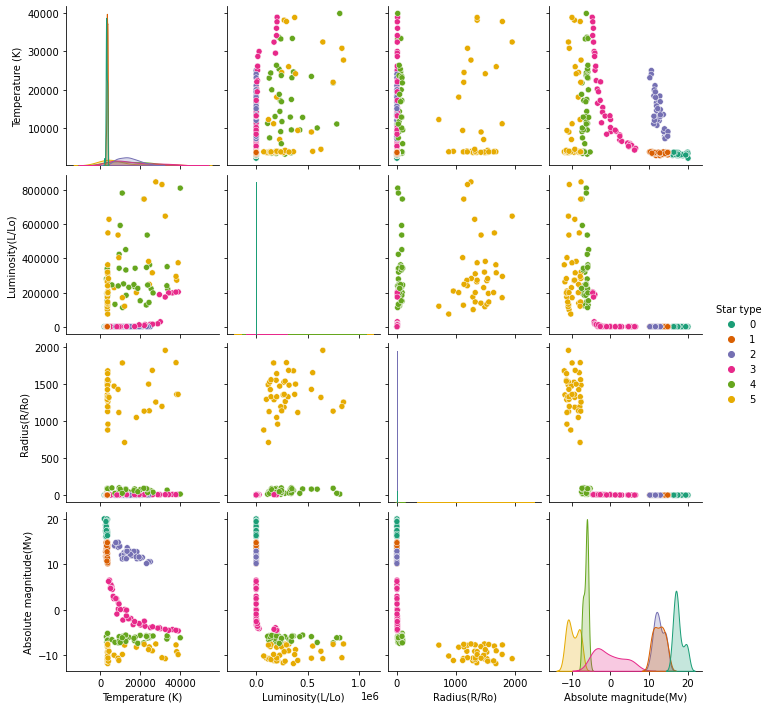

In [4]:
stars_desc = stars_raw.copy()
stars_desc.drop(columns=['Spectral Class', 'Star color'])
sns.pairplot(stars_desc, hue='Star type', palette='Dark2')

### Temperatura

Pierwszym atrybutem jest temperatura gwiazdy podana w Kelwinach. Wartości mieszczą się w zakresie 1939 - 40000. Z histogramu możemy wyczytać, że duża część danych znajduje się przy dolnej granicy zakresu.

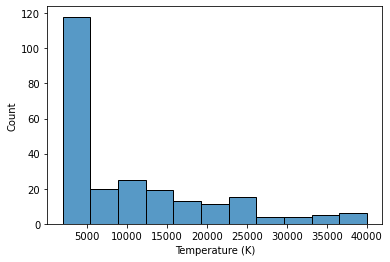

min: 1939, max: 40000


In [5]:
sns.histplot(stars_raw['Temperature (K)'])
plt.show()
print("min:", str(stars_raw['Temperature (K)'].min()) + ", max:", stars_raw['Temperature (K)'].max())

### Jasność

Drugim atrybutem jest względna jasność gwiazdy. Jest ona określona jako wielokrotność jasności Słońca (L/Lo). Tak jak w przypadku rozkładu temperatury, duża część danych znajduje się przy dolnej granicy zakresu.

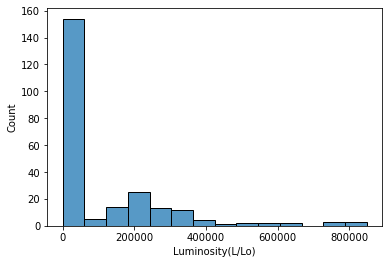

min: 8e-05, max: 849420.0


In [6]:
sns.histplot(stars_raw['Luminosity(L/Lo)'])
plt.show()
print("min:", str(stars_raw['Luminosity(L/Lo)'].min()) + ", max:", stars_raw['Luminosity(L/Lo)'].max())

### Promień

Trzecim atrybutem jest względny promień gwiazdy. Jest on określony jako stosunek promienia gwiazdy do promienia Słońca. 

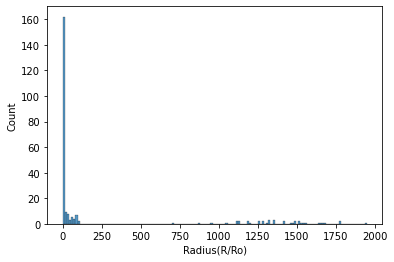

min: 0.0084, max: 1948.5


In [7]:
sns.histplot(stars_raw['Radius(R/Ro)'])
plt.show()
print("min:", str(stars_raw['Radius(R/Ro)'].min()) + ", max:", stars_raw['Radius(R/Ro)'].max())

### Absolutna wielkość gwiazdowa

Czwartym atrybutem jest absolutna wielkość gwiazdy. Jest to miara wielkości gwiazdy liczona z ustalonej odległości 10 parseków. Wartości te mają charakter logarytmiczny, dlatego skala posiada zarówno wartości dodatnie, jak i ujemne.

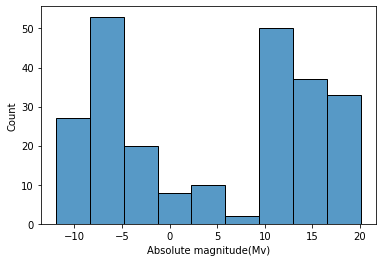

min: -11.92, max: 20.06


In [8]:
sns.histplot(stars_raw['Absolute magnitude(Mv)'])
plt.show()
print("min:", str(stars_raw['Absolute magnitude(Mv)'].min()) + ", max:", stars_raw['Absolute magnitude(Mv)'].max())

### Kolor

Pierwszym atrybutem kategorycznym jest kolor gwiazdy. Jest on opisany za pomocą słów. Co więcej, część nazw jest bardzo podobna do siebie (np. różnią się tylko wielkością liter, dodatkową spacją), co może wskazywać na błąd przy wprowadzaniu danych. Problem ten będzie rozwiązany później.

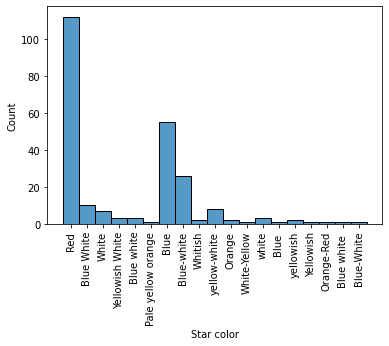

Kolory gwiazd (19):
	"Red"
	"Blue White"
	"White"
	"Yellowish White"
	"Blue white"
	"Pale yellow orange"
	"Blue"
	"Blue-white"
	"Whitish"
	"yellow-white"
	"Orange"
	"White-Yellow"
	"white"
	"Blue "
	"yellowish"
	"Yellowish"
	"Orange-Red"
	"Blue white "
	"Blue-White"


In [9]:
plt.xticks(rotation=90)
sns.histplot(stars_raw['Star color'])
plt.show()
colors = stars_raw['Star color'].unique()
print('Kolory gwiazd (' + str(len(colors)) + '):')
for c in colors:
    print('\t\"' + c + '\"')

Powyżej wypisane są wszystkie nazwy kolorów. Można łatwo zauważyć powtarzające się kategorie kolorów np. 'yellowish' i 'Yellowish'.

### Klasa spektralna

Drugi atrybut kategoryczny. Inaczej zwana typem widmowym lub spektrum widma gwiazdy. Jest ona podzielona przez naukowców na 7 kategorii, które pozwalają na oszacowanie temperatury, składu chemicznego oraz ciśnienia powierzchniowego gwiazdy, a także masy i szacowanego promienia gwiazdy. W obecnej astronomii jest głównym źródłem wiedzy na temat odległych gwiazd.

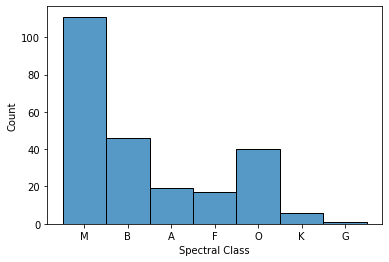

Klasy spektralne: ['M' 'B' 'A' 'F' 'O' 'K' 'G']
Liczba klas spektralnych: 7


In [10]:
sns.histplot(stars_raw['Spectral Class'])
plt.show()
print('Klasy spektralne:', stars_raw['Spectral Class'].unique())
print('Liczba klas spektralnych:', len(stars_raw['Spectral Class'].unique()))

### Typ gwiazdy

Atrybutem decyzyjnym jest typ gwiazdy. Jest on oznaczany poprzez wartość liczbową od 0 do 5. Rozkład tego atrybutu jest równomierny - każda kategoria posiada dokładnie 40 obiektów.
* Typ 0 oznacza brązowego karła, który jest połączeniem pasma głównego gwiazd z pasmem karłów.
* Typ 1 oznacza czerwonego karła, jest to etap przejściowy gwiazdy z pasma głównego do pasma karłów.
* Typ 2 oznacza białe karły, czyli gwiazdy o zbyt małej masie, żeby doprowadzić do reakcji termojądrowych.
* Typ 3 oznacza ciąg główny gwiazd, są to wszystkie gwiazdy w swojej głównej części życia. Należy do nich słońce.
* Typ 4 oznacza olbrzymy, jest to etap przejściowy zwany schyłkiem ewolucji gwiazd z ciągu głównego.
* Typ 5 oznacza nadolbrzymy i hiperolbrzymy najmasywniejsze i najkrócej żyjące gwiazdy, które przemieniają sie w czarne dziury lub gwiazdy neutronwe.

Typy gwiazd: [0 1 2 3 4 5]
Liczba typów gwiazd: 6


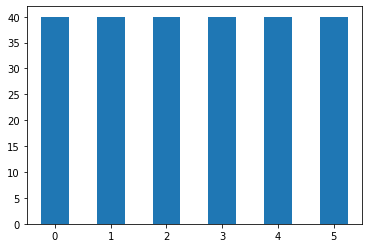

In [11]:
stars_raw['Star type'].value_counts().plot(kind='bar', rot=90)
plt.xticks(rotation='horizontal')
print('Typy gwiazd:', stars_raw['Star type'].unique())
print('Liczba typów gwiazd:', len(stars_raw['Star type'].unique()))

## Przygotowanie danych

Aby utworzyć poprawne i dokładne modele klasyfikatorów, dane powinny zostać wcześniej w odpowiedni sposób przygotowane.

### Podział argumentów opisowych i decyzyjnych

In [12]:
stars_dec = stars_raw['Star type']
stars_des = stars_raw.drop(columns='Star type')

Do utworzenia modelu, dane wejściowe nie powinny zawierać atrybutów decyzyjnych. Cały zestaw danych o gwiazdach został podzielony na 2 części - tylko atrybuty opisujące (stars_des) oraz tylko atrybut decyzyjny (stars_dec).

### Zmiana nazw kolumn

W celu utrzymania porządku część nazw kolumn powinna zostać poprawiona.

In [13]:
stars_des.rename(columns={'Temperature (K)':'Temperature(K)', 'Spectral Class':'Spectral class'}, inplace=True)
print(stars_des.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Temperature(K)          240 non-null    int64  
 1   Luminosity(L/Lo)        240 non-null    float64
 2   Radius(R/Ro)            240 non-null    float64
 3   Absolute magnitude(Mv)  240 non-null    float64
 4   Star color              240 non-null    object 
 5   Spectral class          240 non-null    object 
dtypes: float64(3), int64(1), object(2)
memory usage: 11.4+ KB
None


Zmieniona została nazwą kolumny zawierająca temperatury gwiazd. Jako jedyna posiadała odstęp pomiędzy główną nazwą kolumny a jednostką. Kolejną nazwą, która uległa zmianie jest kolumna klasy spektralnej. W odróżnieniu od pozostałych nazw posiadała w środku dużą literę.

Zmiany te nie mają żadnego istotnego wpływu na proces klasyfikacji, lecz pomogą z konsekwentnością nazw.

### Analiza kolorów gwiazd

Ze względu na dostrzeżone wcześniej podobieństwa pomiędzy nazwami kolorów gwiazd przeprowadzimy teraz analizę, aby sprawdzić z czego wynikają te podobieństwa oraz uprościć dane o ile jest to możliwe.


White:
     Temperature (K)  Luminosity(L/Lo)  Radius(R/Ro)  Absolute magnitude(Mv)  \
21             7740           0.00049       0.01234                   14.02   
22             7220           0.00017       0.01100                   14.23   
23             8500           0.00050       0.01000                   14.50   
81            10574           0.00014       0.00920                   12.02   
82             8930           0.00056       0.00950                   13.78   

    Star type Star color  
21          2      White  
22          2      White  
23          2      White  
81          2      White  
82          2      white  

White-yellow:
     Temperature (K)  Luminosity(L/Lo)  Radius(R/Ro)  Absolute magnitude(Mv)  \
34             5800             0.810         0.900                    5.05   
36             6757             1.430         1.120                    2.41   
37             6380             1.350         0.980                    2.93   
38             5936   

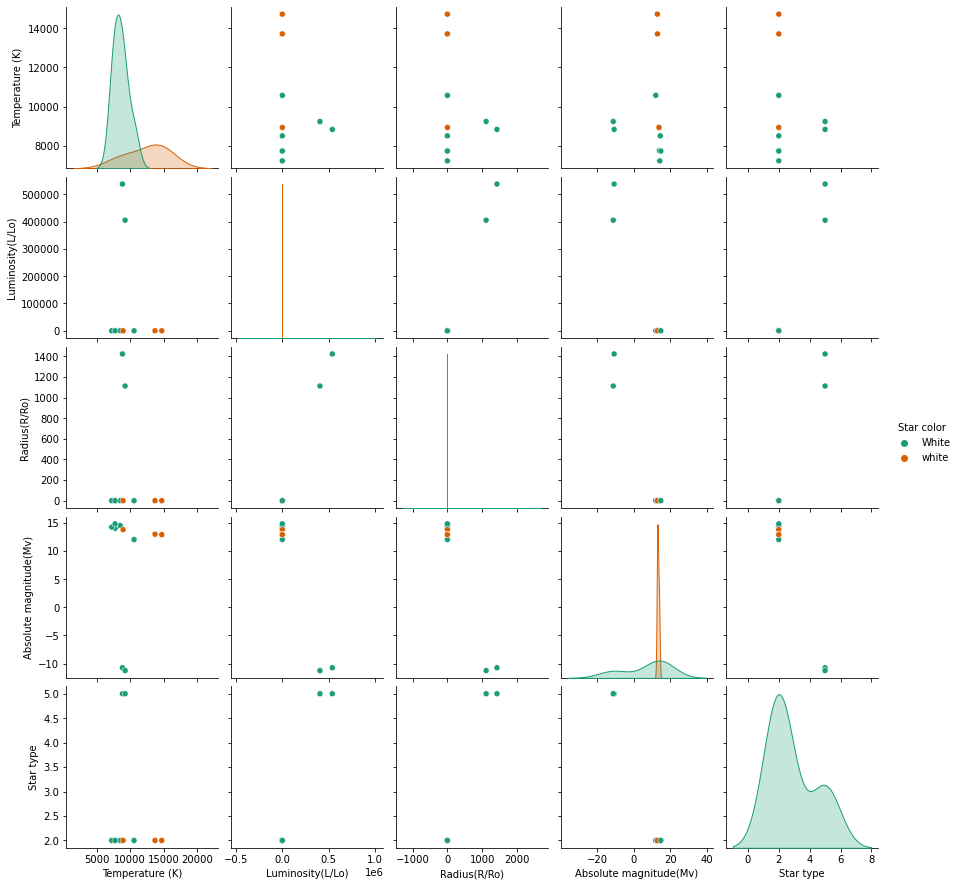

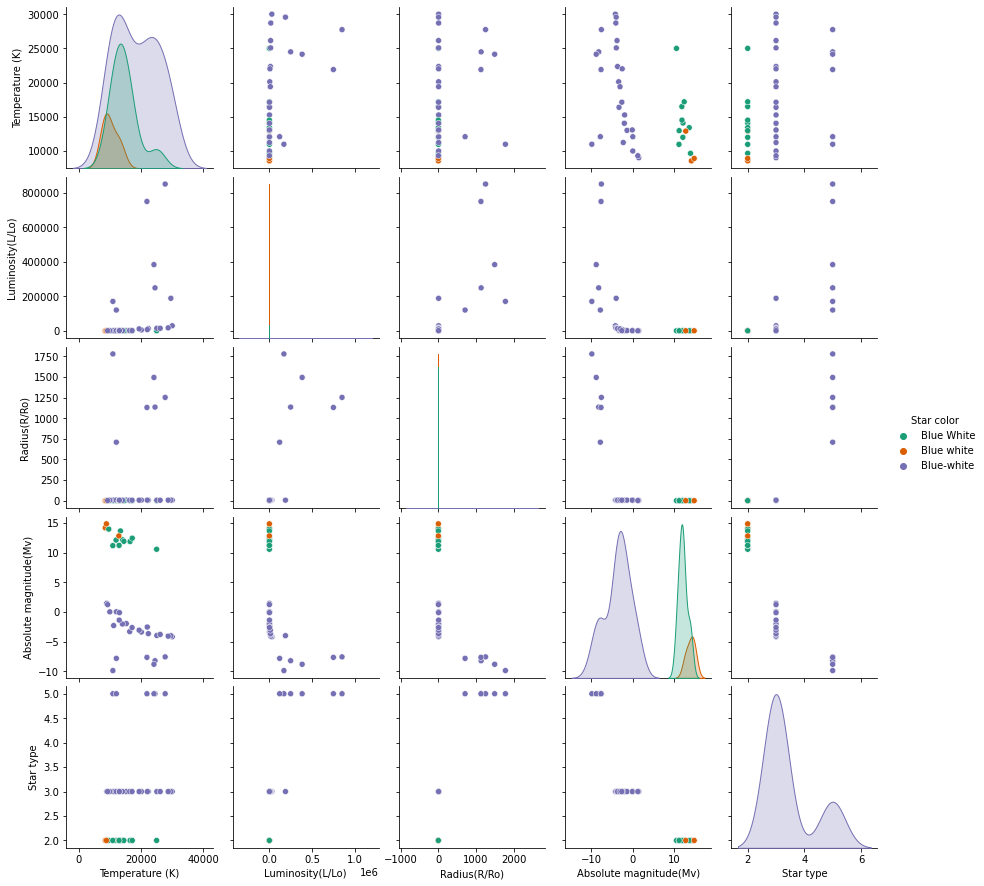

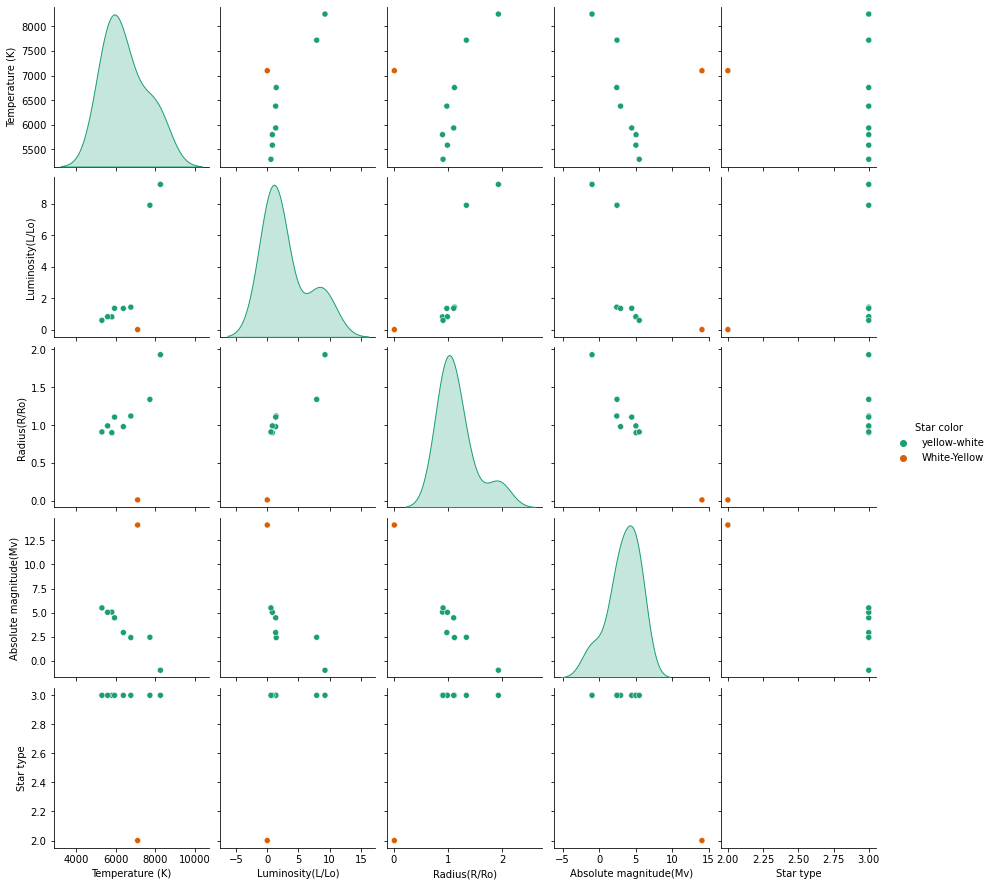

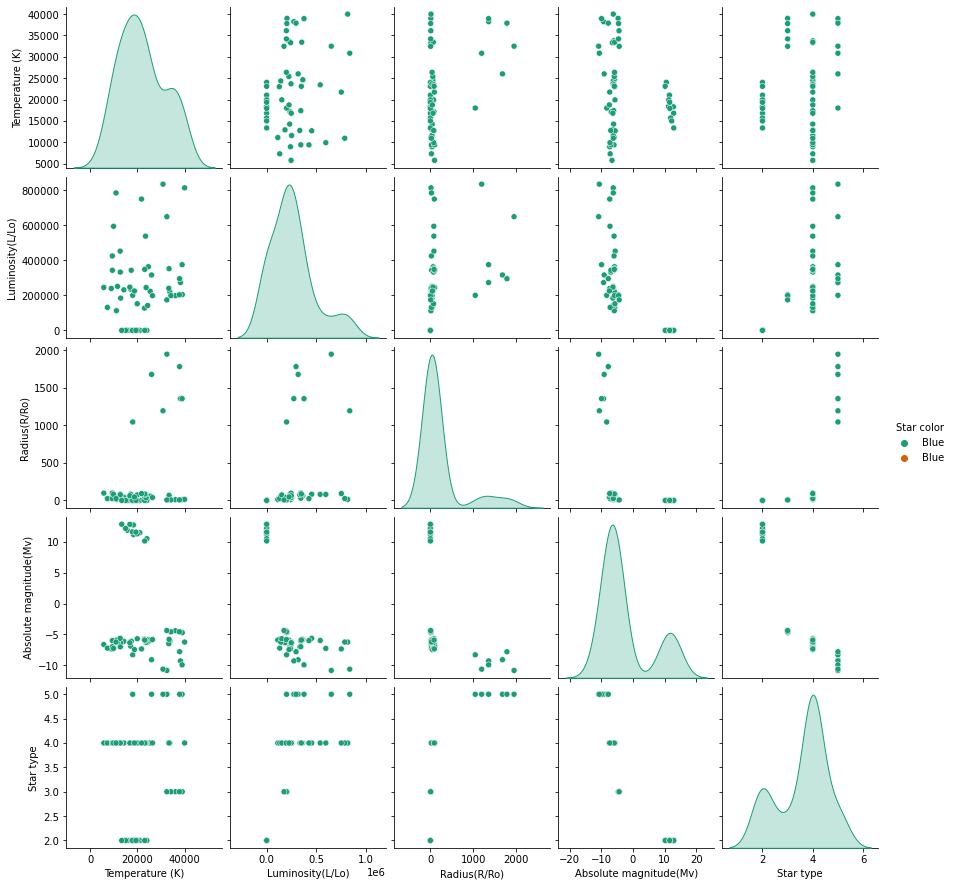

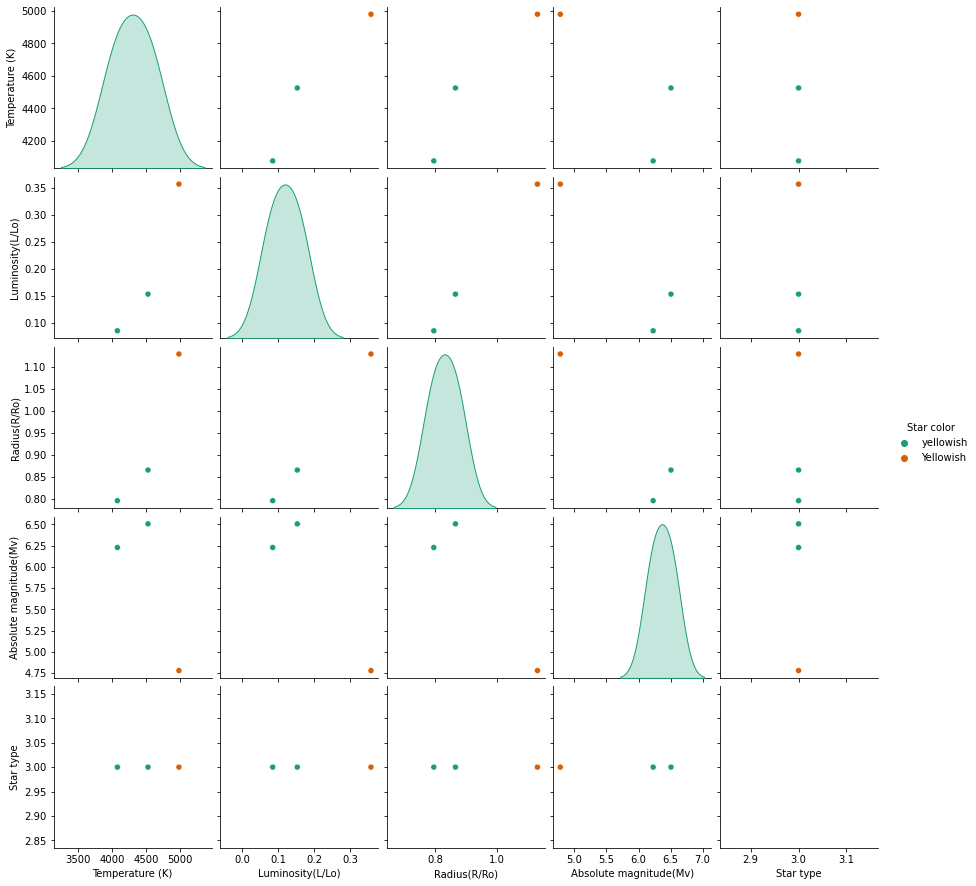

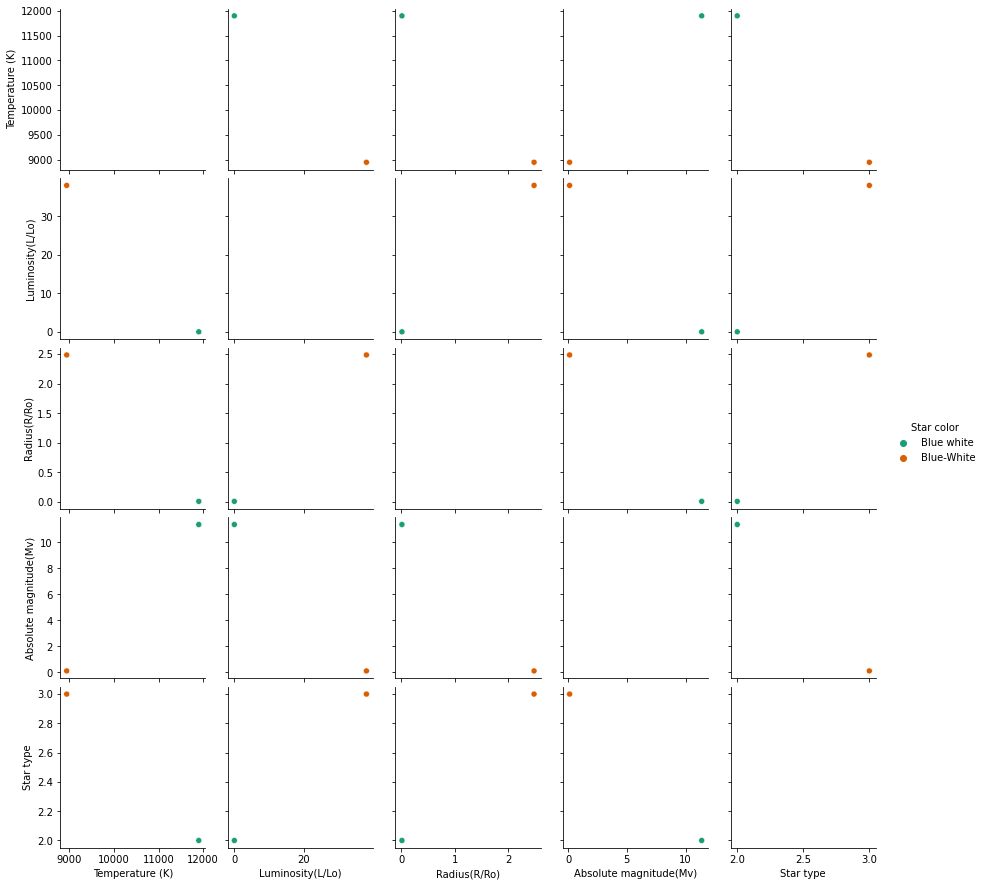

In [14]:
warnings.filterwarnings('ignore')

stars_white = stars_raw.copy()
stars_white = stars_white[stars_white['Star color'].isin(['White', 'white'])]
stars_white = stars_white.drop(columns =['Spectral Class'])
print('\nWhite:\n', stars_white.head())
sns.pairplot(stars_white, hue='Star color', palette='Dark2')

stars_blue_white = stars_raw.copy()
stars_blue_white = stars_blue_white[stars_blue_white['Star color'].isin(['Blue-white', 'Blue White', 'Blue white'])]
stars_blue_white = stars_blue_white.drop(columns =['Spectral Class'])
sns.pairplot(stars_blue_white, hue='Star color', palette='Dark2')

stars_white_yellow = stars_raw.copy()
stars_white_yellow = stars_white_yellow[stars_white_yellow['Star color'].isin(['White-Yellow', 'yellow-white'])]
stars_white_yellow = stars_white_yellow.drop(columns =['Spectral Class'])
print('\nWhite-yellow:\n', stars_white_yellow.head())
sns.pairplot(stars_white_yellow, hue='Star color', palette='Dark2')

stars_blue = stars_raw.copy()
stars_blue = stars_blue[stars_blue['Star color'].isin(['Blue ', 'Blue'])]
stars_blue = stars_blue.drop(columns =['Spectral Class'])
print('\nBlue:\n', stars_blue.head())
sns.pairplot(stars_blue, hue='Star color', palette='Dark2')

stars_yellowish = stars_raw.copy()
stars_yellowish = stars_yellowish[stars_yellowish['Star color'].isin(['yellowish', 'Yellowish'])]
stars_yellowish = stars_yellowish.drop(columns =['Spectral Class'])
print('\nYellowish:\n', stars_yellowish.head())
sns.pairplot(stars_yellowish, hue='Star color', palette='Dark2')

stars_blue_white = stars_raw.copy()
stars_blue_white = stars_blue_white[stars_blue_white['Star color'].isin(['Blue white ', 'Blue-White'])]
stars_blue_white = stars_blue_white.drop(columns =['Spectral Class'])
print('\nBlue-white:\n', stars_blue_white.head())
sns.pairplot(stars_blue_white, hue='Star color', palette='Dark2')

Po zwizualizowaniu gwiazd wraz z ich parametrami opisowymi można zauważyć, że kolory choć z pozoru mają takie same znaczenie, opisują jednak inne rodzaje gwiazd należących do różnych pasm. Z tego powodu decyduje się na połączenie tylko tych kolorów, dla których nie jestem w stanie stwierdzić tego, że opisują oddzielne grupy gwiazd.
* Kolory 'white' i 'White' można połączyć, ponieważ nie da się stwierdzić znaczących różnic pomiędzy nimi.
* Kolory 'Blue white' oraz Blue White' opisują białe karły i wyraźnie różnią się od 'Blue-White', które opisuje resztę spektrum gwiazd mających ten kolor. Z tego powdu uznałem, że połącznie 'Blue white' oraz 'Blue White' nie będzie powodowało błędów w dalszej analizie.
* Podobna sytuacja pojawia się dla 'yellow-white' oraz 'White-Yellow'. Drugi kolor opisuje białego karła a pierwszy całą resztę spketrum gwiazd w tym kolorze, dlatego rezygnuję z połączenia tych dwóch kolorów. 
* Dla sytuacji 'Blue' i 'Blue ' pomarańczowa kropka zlewa się z niebieskimi, dlatego tę spację w nazwie koloru uznaję jako błąd i decyduję się na połączenie tych dwóch barw. 
* Kolory 'yellowish' i 'Yellowish' oba opisują gwiazdy w głównym paśmie. Choć na wykresach te dwa zbiory są wyraźnie oddzielne od siebie to jest to spowodowane małą podziałką skali, a odległości są stosunkowo małe patrząc na ogół skali gwiezdnej. Dlatego decyduję się na połączenie tych dwóch barw. 
* 'Blue white' i 'Blue-White' opisują dwie skrajnie różne gwiazdy. 'Blue white' opisuje białego karła natomiast 'Blue-White' opisuje gwiazdę z głównego pasma. Z tego powodu nie połączę tych dwóch kolorów.

In [15]:
stars_raw['Star color'].replace({'white' : 'White'}, inplace=True)
stars_raw['Star color'].replace({'Blue white ': 'Blue White'}, inplace=True)
stars_raw['Star color'].replace({'Blue ' : 'Blue'}, inplace=True)
stars_raw['Star color'].replace({'yellowish' : 'Yellowish'}, inplace=True)

colors = stars_raw['Star color'].unique()
print('Kolory gwiazd (' + str(len(colors)) + '):')
for c in colors:
    print('\t\"' + c + '\"')

Kolory gwiazd (15):
	"Red"
	"Blue White"
	"White"
	"Yellowish White"
	"Blue white"
	"Pale yellow orange"
	"Blue"
	"Blue-white"
	"Whitish"
	"yellow-white"
	"Orange"
	"White-Yellow"
	"Yellowish"
	"Orange-Red"
	"Blue-White"


### Zmiana atrybutów kategorycznych na ilościowe

Klasyfikatory, które zostaną użyte w dalszej części, nie akceptują danych kategorycznych. Rozwiązaniem tego problemu jest zamiana wszystkich atrybutów kategorycznych (kolor gwiazd oraz klasa spektralna) na atrybuty ilościowe.

In [16]:
encoder = OrdinalEncoder()
stars_des[['Star color', 'Spectral class']] = encoder.fit_transform(stars_des[['Star color', 'Spectral class']])
stars_des.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Temperature(K)          240 non-null    int64  
 1   Luminosity(L/Lo)        240 non-null    float64
 2   Radius(R/Ro)            240 non-null    float64
 3   Absolute magnitude(Mv)  240 non-null    float64
 4   Star color              240 non-null    float64
 5   Spectral class          240 non-null    float64
dtypes: float64(5), int64(1)
memory usage: 11.4 KB


Użyty został OrdinalEncoder z pakietu sklearn.preprocessing (https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OrdinalEncoder.html). Jego działanie jest dosyć proste - zamienia znaki / łańcuchy znaków reprezentujące kategorie na kolejne liczby. Np. kolor 'Red' zostanie zamieniony na 1, kolor 'White' na 2, itp.

Poniżej wypisane są nowe wartości w kolumnach 'Star color' i 'Spectral class'

In [17]:
print('Star color:', np.sort(stars_des['Star color'].unique()))
print('Spectral class:', np.sort(stars_des['Spectral class'].unique()))

Star color: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18.]
Spectral class: [0. 1. 2. 3. 4. 5. 6.]


### Sprawdzenie korelacji atrybutów dla całego zbioru

Jeżeli okaże się, że któreś atrybuty posiadają dużą korelację, możliwe będzie usunięcie części z nich w celu uproszczenia danych dla modelu.

<AxesSubplot:>

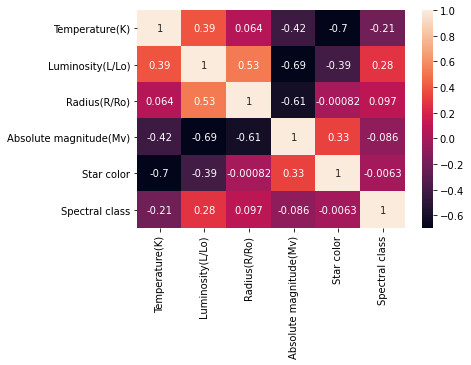

In [18]:
sns.heatmap(stars_des.corr(), annot=True)

Żadne atrybuty opisowe nie posiadają między sobą większej korelacji w zakresie całego zbioru. Największa korelacja występuje pomiędzy temperaturą a kolorem gwiazdy (ma to sens, gdyż kolor ciała zależy od jego temperatury https://pl.wikipedia.org/wiki/Cia%C5%82o_doskonale_czarne). Jednak wartość -0.7 jest zbyt mała, żeby pozbyć się jednej z kolumn.

### Analiza atrybutu Spectral class

W astrofizyce klasa spektrum jest głównym źródłem informacji o obserwowanej gwieździe. Jednak klasy spektralne są wymysłem ludzkim gdzie dla każdek klasy jest przydzielony pewien zakres wartości. Na początku przeanalizuję średnie wartości dla poszczególnych klas. A następnie przeanalizuję klasy spektralne za pomocą wartości z tablic astrofizycznych. Warto także wspomnieć że klasy spektralne w zbiorze danych są nie koniecznie idealnie napisane. Ponieważ dwie skrajne klasy mają przedziały otwarte. Astrofizycy uszczegółowili te klasy dla skrajnie małych i skrajnie dużych wartości dlatego poniższa analiza skupia się głównie na ciągu głównym gwiazd.

#### Klasa spektralna dla ciągu głównego

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6 entries, 0 to 6
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Temperature (K)         6 non-null      float64
 1   Luminosity(L/Lo)        6 non-null      float64
 2   Radius(R/Ro)            6 non-null      float64
 3   Absolute magnitude(Mv)  6 non-null      float64
dtypes: float64(4)
memory usage: 240.0 bytes


<AxesSubplot:xlabel='Spectral Class'>

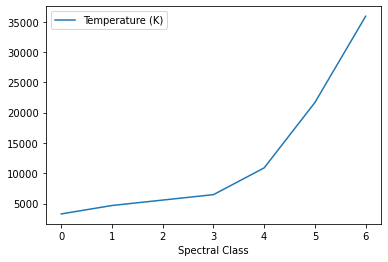

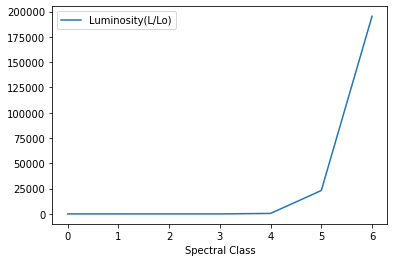

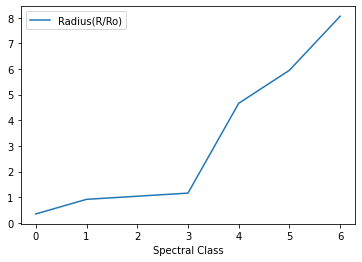

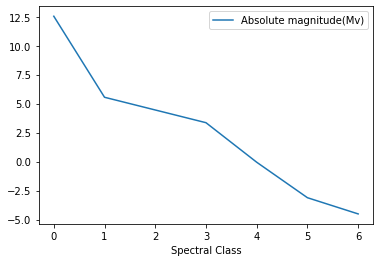

In [19]:
stars_spectral = stars_raw.copy()
stars_spectral = stars_spectral.loc[stars_spectral['Star type'] != 2]
stars_spectral = stars_spectral.loc[stars_spectral['Star type'] < 4]
stars_spectral = stars_spectral.loc[stars_spectral['Star type'] != 0]
stars_spectral = stars_spectral.drop(columns=['Star type', 'Star color'])
stars_spectral['Spectral Class'].replace({'M' : '0'}, inplace=True)
stars_spectral['Spectral Class'].replace({'K' : '1'}, inplace=True)
stars_spectral['Spectral Class'].replace({'G' : '2'}, inplace=True)
stars_spectral['Spectral Class'].replace({'F' : '3'}, inplace=True)
stars_spectral['Spectral Class'].replace({'A' : '4'}, inplace=True)
stars_spectral['Spectral Class'].replace({'B' : '5'}, inplace=True)
stars_spectral['Spectral Class'].replace({'O' : '6'}, inplace=True)
stars_spectral.astype({"Spectral Class" : int})
convert_dict = {'Spectral Class':int}
stars_spectral = stars_spectral.astype(convert_dict)
stars_spectral = stars_spectral.groupby(['Spectral Class']).mean()
stars_spectral.info()
stars_spectral[['Temperature (K)']].plot()
stars_spectral[['Luminosity(L/Lo)']].plot()
stars_spectral[['Radius(R/Ro)']].plot()
stars_spectral[['Absolute magnitude(Mv)']].plot()

Temperatura oraz jasność gwiazd zachowują się podobnie względem klas spektrum. Promień także zachowuje się podobnie do dwóch wcześniejszych atrybutów. Warto pamiętać że te 3 wartości mają charakter linowy, natomiast wielkość ma charakter logarytmiczny i odwrotny, czyli im mniejsza wartość tym gwiazda jest logarytmicznie większa.

#### Klasa spektrum w połączeniu z tablicami astrofizycznymi

W tabelach astrofizycznych zależność temperatury oraz masy od klasy gwiazdy mają bardzo podobny charakter. Dlatego zamiast klasy spektralnej podstawiam wartości przewidziane przez naukowców. Nie biorę pod uwagę rodziny karłów ze względu na osobne klasy spektralne, które opisują najmniejsze i najzimniejsze obiekty takie jak brązowe karły (L,T,Y). Odrzucam także nadolbrzymy i hiperolbrzymy ze względu na fakt, że klasa O jest też dla nich uszczegółowiona (W,Q,C,S). Samo określenie klasą O jest poprawne z punktu widzenia astrofizyki, jednak może być bardzo mylące podczas analizy danych. <br>
Problemem jest klasa 0, ponieważ jest ona klasą otwartą, nie posiada górnego zakresu, dlatego w zależności od użytej wartości dla tej klasy, zależności się różnią. 

<AxesSubplot:>

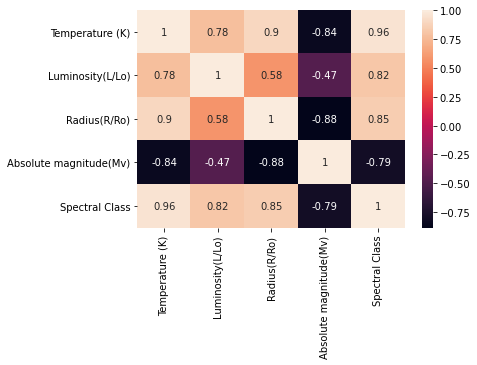

In [20]:
stars_spectral_table = stars_raw.copy()
stars_spectral_table = stars_spectral_table.loc[stars_spectral_table['Star type'] != 2]
stars_spectral_table = stars_spectral_table.loc[stars_spectral_table['Star type'] < 4]
stars_spectral_table = stars_spectral_table.loc[stars_spectral_table['Star type'] != 0]
stars_spectral_table = stars_spectral_table.drop(columns=['Star type', 'Star color'])
stars_spectral_table['Spectral Class'].replace({'M' : '3000'}, inplace=True)
stars_spectral_table['Spectral Class'].replace({'K' : '4400'}, inplace=True)
stars_spectral_table['Spectral Class'].replace({'G' : '5600'}, inplace=True)
stars_spectral_table['Spectral Class'].replace({'F' : '6750'}, inplace=True)
stars_spectral_table['Spectral Class'].replace({'A' : '8750'}, inplace=True)
stars_spectral_table['Spectral Class'].replace({'B' : '20000'}, inplace=True)
stars_spectral_table['Spectral Class'].replace({'O' : '40000'}, inplace=True)
stars_spectral_table = stars_spectral_table.astype({"Spectral Class" : int})
sns.heatmap(stars_spectral_table.corr(), annot=True)


<AxesSubplot:>

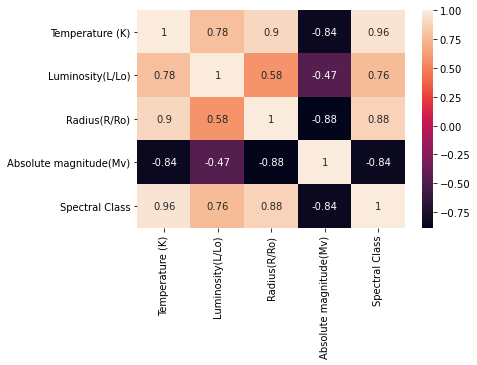

In [21]:
stars_spectral_table['Spectral Class'].replace({40000 : 33000}, inplace=True)
sns.heatmap(stars_spectral_table.corr(), annot=True)

A teraz podstawię pod klasę spektrum średnie wartości przewidywane przez naukowców w tablicach dla promienia gwiazdy.

<AxesSubplot:>

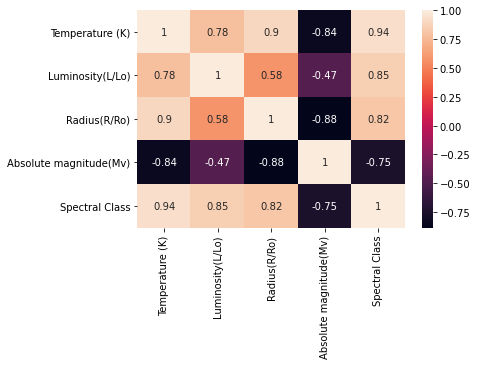

In [22]:
stars_spectral_table_rad = stars_raw.copy()
stars_spectral_table_rad = stars_spectral_table_rad.loc[stars_spectral_table_rad['Star type'] != 2]
stars_spectral_table_rad = stars_spectral_table_rad.loc[stars_spectral_table_rad['Star type'] < 4]
stars_spectral_table_rad = stars_spectral_table_rad.loc[stars_spectral_table_rad['Star type'] != 0]
stars_spectral_table_rad = stars_spectral_table_rad.drop(columns=['Star type', 'Star color'])
stars_spectral_table_rad['Spectral Class'].replace({'M' : '0.5'}, inplace=True)
stars_spectral_table_rad['Spectral Class'].replace({'K' : '0.83'}, inplace=True)
stars_spectral_table_rad['Spectral Class'].replace({'G' : '1.06'}, inplace=True)
stars_spectral_table_rad['Spectral Class'].replace({'F' : '1.28'}, inplace=True)
stars_spectral_table_rad['Spectral Class'].replace({'A' : '1.6'}, inplace=True)
stars_spectral_table_rad['Spectral Class'].replace({'B' : '4.2'}, inplace=True)
stars_spectral_table_rad['Spectral Class'].replace({'O' : '10'}, inplace=True)
stars_spectral_table_rad = stars_spectral_table_rad.astype({"Spectral Class" : float})
sns.heatmap(stars_spectral_table_rad.corr(), annot=True)

<AxesSubplot:>

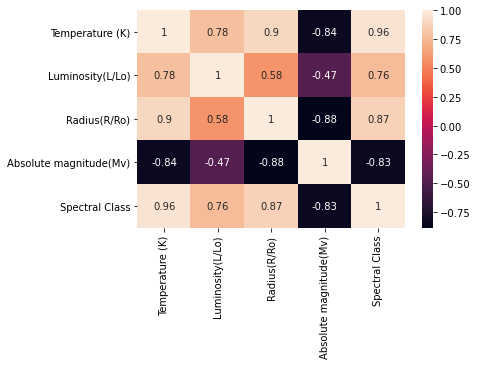

In [23]:
stars_spectral_table_rad['Spectral Class'].replace({10 : 7}, inplace=True)
sns.heatmap(stars_spectral_table_rad.corr(), annot=True)

#### Wnioski

Zgodnie z przewidywaniami Spectral Class jest bardzo silnie skorelowana z resztą parametrów gwiazd. Gdyby do wyznaczania wartości Spectral Class użyć równań astrofizycznych zamiast wartości śrenich z tabel okazałoby się że dane są jeszcze bardziej ze sobą skorelowane. Także usatalenie wartości dla skrajnych Class powoduje pewne zawachania co do korelacji argumentów. Jednak pomimo tych wszystkich czynników udało się osiągnąć korelacje na poziomie 0.96 z Temperaturą, 0.85 z jasnością, 0.88 z promieniem oraz 0.83 z wielkością. Spektrum gwiazdy zależy od jej temperatury powierzchniowej oraz skłądu chemicznego. Temperatura zależy od ciśnienia, natomiast ciśnienie zależy od masy i gęstości gwiazdy, a gęstość to relacja masy i promienia. Dlatego Spectral Class w połączeniu z tablicami astrofizycznymi jest najbardziej wartościowym argumentem ze względu na możliwość oszacowania na jego podstawie reszty atrybutów.

### Sprawdzanie korelacji poszczególnych wartości atrybutów w kolejnych ciągach

Podczas wstępnego opsiania obiektów zauważyłem kilka prawdopodobnych korelacji które uznałem że warto sprawdzić. Także z astrofizyki wynikają pewne zależości które chciałbym potwierdzić na badanych danych. Porównanie bezpośrednie całego zbioru jest chybione ze względu na fakt że każda klasa obiektów polega na innych zjawiskach astrofizycznych. Dlatego przeprowadzę analizę w podzbiorach które polegają na takich zjawiskach fizycznych oraz mają inne pochodzenie.

#### Ciąg białych karłów

<AxesSubplot:>

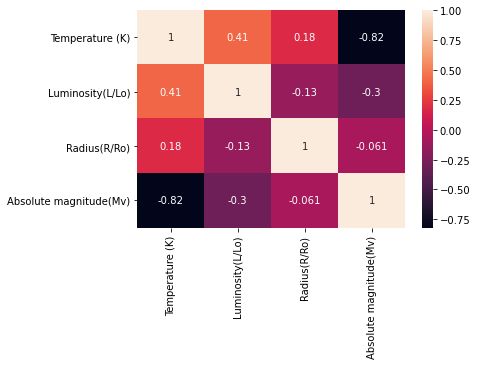

In [24]:
stars_dwarf = stars_raw.copy()
stars_dwarf = stars_dwarf.loc[stars_dwarf['Star type'] == 2]
stars_dwarf = stars_dwarf.drop(columns=['Star type'])
sns.heatmap(stars_dwarf.corr(), annot=True)

#### Ciąg główny

<AxesSubplot:>

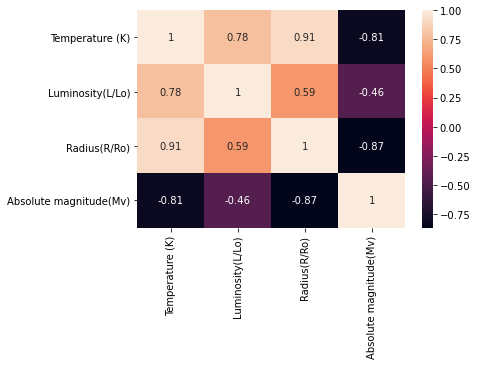

In [25]:
stars_main = stars_raw.copy()
stars_main = stars_main.loc[stars_main['Star type'] <4 ]
stars_main = stars_main.loc[stars_main['Star type'] != 2]
stars_main = stars_main.drop(columns=['Star type'])
sns.heatmap(stars_main.corr(), annot=True)

#### Ciąg olbrzymów

<AxesSubplot:>

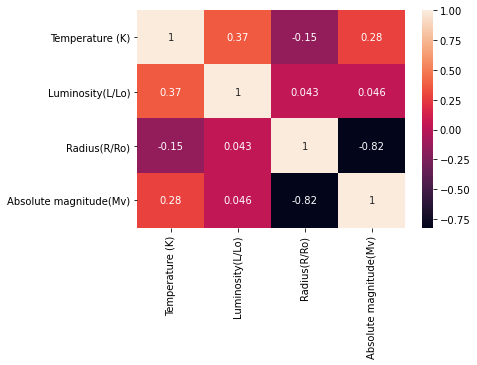

In [26]:
stars_giants = stars_raw.copy()
stars_giants = stars_giants.loc[stars_giants['Star type'] >= 4 ]
stars_giants = stars_giants.drop(columns=['Star type'])
sns.heatmap(stars_giants.corr(), annot=True)

#### Wnioski

* Białe karły to jedna z najszerszych badanych grup gwiazd. Jedyną znaczącą korelacją jest zależność Temperatury od wielkości. Natomiast cała reszta atrynutów jest w bardzo małym stopniu ze sobą skorelowana. <br>
* Ciąg główny jest najbardziej przewidywalnym zbiorem gwiazd na który się składą 3 klasy. Ciąg główny, czerwone oraz brązowe karły. Występują bardzo silne zależności pomiędzy temperaturą a promieniem 0.91, temperaturą a wielkością -0.81 oraz promieniem a wielkością -0.87. Występuje także całkiem duża zależność pomiędzy temperaturą a jasnością. Posiadają także nawiększe zależności pomiędzy jasnością a promieniem i wielkością wśród badanych obiektów, które wynoszą 0.59 oraz -0.46 <br>
* Ostatnią a także największą grupą są olbrzymy oraz nadolbrzymy. Jedyna znacząca zależność występuje pomiędzy wielkością a promieniem gwiazdy. Cała reszta korelacji jest bardzo mała,  0.37 i 0.28 lub całkowicie pomijalna, poniżej 0,01.

### Atrybuty decyzyjne

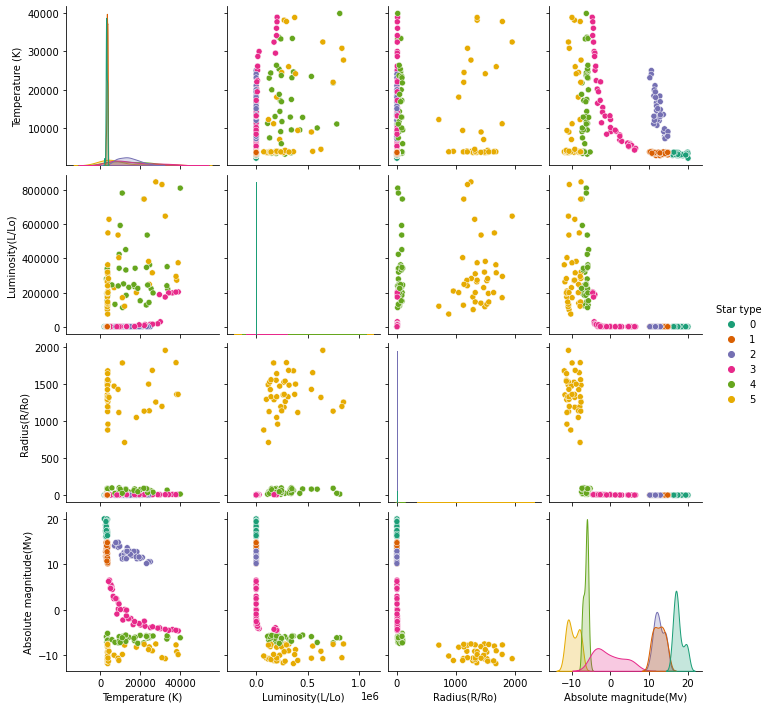

In [27]:
sns.pairplot(stars_desc, hue='Star type', palette='Dark2')

Dzięki przeprowadzonej wyżej analizie kolorów można znaleźć pewne kolory które jednoznacznie wskazują przynależność do klasy
* Kolor Blue White jednoznacznie określa przynależność gwiazdy do klasy 2 czyli białych karłów
* Kolor White-Yellow także jednoznacznie określa gwiazdy należące do typu 2 - białych karłów
* Kolor yellow-white jest określeniem zarezerwowanym dla gwiazd typu 3 - gwiazd głównego pasma
* Kolor Uellowish jest kolorem występującym tylko w połączeniu z gwiazdami typu 3 - gwiazdami łańcucha głównego
* Kolor Blue white występuje w połączeniu z gwiazdą typu 2 - białym karłem
* Kolor Blue-White określa gwiazdę typu 3 - gwiazd głównego pasma<br>
Oprócz tego do atrybutów decyzyjnych możemy zaliczyć Radius, dzieki któremu możemy jednoznacznie wyznaczyć hiperolbrzymy. <br>
Połączenie wielkości wraz z temperaturą pozwala na wyznaczenie typów 0, 1, 2 i 3 oraz rozdzelić olbrzymy i  hiperolbrzymy od reszty gwiazd.

### Skalowanie danych

Dane w zbiorze posiadają różne przedziały wielkości. Aby ulepszyć działanie modelu, należy wcześniej przeskalować wszystkie atrybuty, aby każdy z nich miał podobny wpływ na wynik przewidywania typu gwiazdy.

[Text(0, 0, 'Temperature(K)'),
 Text(1, 0, 'Luminosity(L/Lo)'),
 Text(2, 0, 'Radius(R/Ro)'),
 Text(3, 0, 'Absolute magnitude(Mv)'),
 Text(4, 0, 'Star color'),
 Text(5, 0, 'Spectral class')]

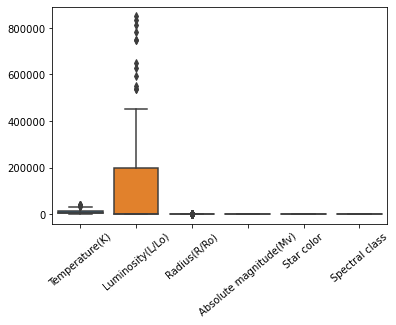

In [28]:
plot = sns.boxplot(data=stars_des)
plot.set_xticklabels(plot.get_xticklabels(), rotation=40)

Wartości posiadają różne zakresy. Do ich przeskalowania zostanie użyty StandardScaler z pakietu sklearn.preprocessing (https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html). Normalizuje on wszystkie kolumny na podstawie ich wartości średniej i odchylenia standardowego według wzoru: nowa_wartość = (obecna_wartość - średnia) / odchylenie.

<AxesSubplot:>

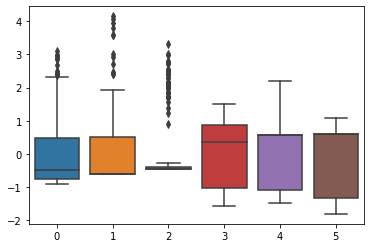

In [29]:
scaler = StandardScaler()
stars_des = scaler.fit_transform(stars_des)
sns.boxplot(data=stars_des)

Po przeskalowaniu dane mają podobne zakresy wartości.

### Podział danych na treningowe i testowe

Do sprawdzenia poprawności działania modelu potrzebny będzie zestaw danych testowych. Z racji tego, że dysponujemy jedynie 240 rekordami, podzielimy je w taki sposób, że 40 zostanie użyte do testowania, a 200 do treningu (proporcja 16,66%). Podział jest losowy, dlatego przydział obiektów do podzbiorów będzie się różnił w kolejnych uruchomieniach kodu.

In [30]:
def podzielDane():
    global stars_des_train
    global stars_des_test
    global stars_dec_train
    global stars_dec_test
    stars_des_train, stars_des_test, stars_dec_train, stars_dec_test = train_test_split(stars_des, stars_dec, test_size=0.1666)

## Porównanie modelów różnych klasyfikatorów

W celu sprawdzenia najlepszej metody klasyfikacji wykorzystamy kilka klasyfikatorów z różnymi parametrami: k-NN, prototypów, Bayesa oraz drzew decyzyjnych. Każdy klasyfikator jest testowany wiele razy (iterationCount). Za każdym razem dane są od nowa mieszane i dzielone na zestawy treningowe i testowe. Dzięki temu w każdej iteracji testów klasyfikator dostanie trochę inne dane.

### Klasyfikator najbliższych sąsiadów (k-NN)

In [31]:
iterationCount = 50
kCount = 20
trainScores = [[0 for x in range(iterationCount)] for y in range(kCount)]
testScores = [[0 for x in range(iterationCount)] for y in range(kCount)]

for i in range(iterationCount):
    podzielDane()
    for k in range(1,kCount+1):
        model = KNeighborsClassifier(n_neighbors=k)
        model.fit(stars_des_train, stars_dec_train)
        trainScores[k-1][i] = model.score(stars_des_train, stars_dec_train)
        testScores[k-1][i] = model.score(stars_des_test, stars_dec_test)

for k in range(1,kCount+1):
    print(str(k) + ':\ttrening: %.3f' % np.mean(trainScores[k-1]), '\ttest: %.3f' % np.mean(testScores[k-1]))

1:	trening: 1.000 	test: 0.979
2:	trening: 0.981 	test: 0.963
3:	trening: 0.983 	test: 0.965
4:	trening: 0.967 	test: 0.962
5:	trening: 0.969 	test: 0.962
6:	trening: 0.965 	test: 0.959
7:	trening: 0.966 	test: 0.956
8:	trening: 0.964 	test: 0.955
9:	trening: 0.961 	test: 0.950
10:	trening: 0.960 	test: 0.946
11:	trening: 0.950 	test: 0.949
12:	trening: 0.948 	test: 0.942
13:	trening: 0.947 	test: 0.939
14:	trening: 0.943 	test: 0.933
15:	trening: 0.941 	test: 0.930
16:	trening: 0.938 	test: 0.929
17:	trening: 0.934 	test: 0.925
18:	trening: 0.928 	test: 0.917
19:	trening: 0.922 	test: 0.911
20:	trening: 0.905 	test: 0.894


Klasyfikator k-NN osiągnął dosyć dobre wyniki dla mniejszych k. Był on testowany dla zakresu parametru k wynoszącego: od 1 do 20. Dla k=1 celność modelu jest najwyższa i wynosi: dla danych treningowych - 1.00; dla danych testowych - 0.98. Wraz ze wzrostem parametru k, celność zaczyna spadać.

### Klasyfikator prototypów

In [32]:
iterationCount = 200
trainScores = [0 for x in range(iterationCount)]
testScores = [0 for x in range(iterationCount)]

for i in range(iterationCount):
    podzielDane()
    model = NearestCentroid()
    model.fit(stars_des_train, stars_dec_train)
    trainScores[i] = model.score(stars_des_train, stars_dec_train)
    testScores[i] = model.score(stars_des_test, stars_dec_test)

print('trening: %.3f' % np.mean(trainScores), '\ttest: %.3f' % np.mean(testScores))

trening: 0.897 	test: 0.874


Klasyfikator prototypów okazał się na razie najgorszym klasyfikatorem. Po 200 iteracjach testów osiągnął on celność wynoszącą tylko: trening - 0.90; test - 0.88. Są do słabe wyniki w zestawieniu z innymi klasyfikatorami.

### Klasyfikator Bayesa

In [33]:
iterationCount = 200
trainScores = [0 for x in range(iterationCount)]
testScores = [0 for x in range(iterationCount)]

for i in range(iterationCount):
    podzielDane()
    model = GaussianNB()
    model.fit(stars_des_train, stars_dec_train)
    trainScores[i] = model.score(stars_des_train, stars_dec_train)
    testScores[i] = model.score(stars_des_test, stars_dec_test)

print('trening: %.3f' % np.mean(trainScores), '\ttest: %.3f' % np.mean(testScores))

trening: 0.986 	test: 0.979


Naiwny klasyfikator Bayesa jest dość dobry dla tego zestawu danych. Osiągną on celność podobną do klasyfikatora najbliższych sąsiadów (k=1). Jego przewagą jest to, że jest on znacznie szybszy od innych klasyfikatorów.

### Klasyfikator drzew decyzyjnych

In [34]:
iterationCount = 100
depthCount = 30
trainScores = [[0 for x in range(iterationCount)] for y in range(depthCount)]
testScores = [[0 for x in range(iterationCount)] for y in range(depthCount)]

for i in range(iterationCount):
    podzielDane()
    for d in range(1,depthCount+1):
        model = tree.DecisionTreeClassifier(max_depth=d)
        model.fit(stars_des_train, stars_dec_train)
        trainScores[d-1][i] = model.score(stars_des_train, stars_dec_train)
        testScores[d-1][i] = model.score(stars_des_test, stars_dec_test)

for d in range(1,depthCount+1):
    print(str(d) + ':\ttrening: %.3f' % np.mean(trainScores[d-1]), '\ttest: %.3f' % np.mean(testScores[d-1]))

1:	trening: 0.354 	test: 0.232
2:	trening: 0.538 	test: 0.401
3:	trening: 0.752 	test: 0.638
4:	trening: 0.932 	test: 0.884
5:	trening: 1.000 	test: 0.994
6:	trening: 1.000 	test: 0.994
7:	trening: 1.000 	test: 0.995
8:	trening: 1.000 	test: 0.996
9:	trening: 1.000 	test: 0.995
10:	trening: 1.000 	test: 0.995
11:	trening: 1.000 	test: 0.994
12:	trening: 1.000 	test: 0.996
13:	trening: 1.000 	test: 0.994
14:	trening: 1.000 	test: 0.995
15:	trening: 1.000 	test: 0.996
16:	trening: 1.000 	test: 0.995
17:	trening: 1.000 	test: 0.996
18:	trening: 1.000 	test: 0.995
19:	trening: 1.000 	test: 0.995
20:	trening: 1.000 	test: 0.995
21:	trening: 1.000 	test: 0.995
22:	trening: 1.000 	test: 0.995
23:	trening: 1.000 	test: 0.993
24:	trening: 1.000 	test: 0.995
25:	trening: 1.000 	test: 0.995
26:	trening: 1.000 	test: 0.995
27:	trening: 1.000 	test: 0.996
28:	trening: 1.000 	test: 0.996
29:	trening: 1.000 	test: 0.995
30:	trening: 1.000 	test: 0.994


Klasyfikator drzew decyzyjnych ma najlepsze wyniki spośród wszystkich testowanych tu klasyfikatorów. Dla każdej zadanej maksymalnej głębokości większej od 5 celność predykcji na zestawie treningowym wyniosła 1.00. Celność na zestawie testowym również jest bardzo dobra - nigdy nie była mniejsza od 0.99. Skoro parametr głębokości nie ma większego wpływu na celność predykcji od pewnego momentu, lepiej jest używać jego mniejszych wartości (np. maxDepth=8). Duża głębokość negatywnie wpływa na skomplikowanie modelu klasyfikatora, a nie daje lepszych rezultatów.

### Wnioski

- Najlepszym klasyfikatorem dla tego zestawu danych jest klasyfikator drzew decyzyjnych. Osiągną on najlepsze wyniki oraz jego trenowanie nie zajmuje dużo czasu. 
- Drugim najlepszym klasyfikatorem jest naiwny klasyfikator Bayesa. Jest on szybki i dosyć celny. Pomimo tego, że jego wynik jest podobny do wyniku klasyfikatora k-NN (k=1), to jego proces trenowania jest znacznie szybszy.